In [30]:
%%javascript 
// To get notebook's full path
var kernel = Jupyter.notebook.kernel; 
var command = ["notebookPath = ",
               "'", window.document.body.dataset.notebookPath, "'" ].join('')
//alert(command)
kernel.execute(command)
var command = ["notebookName = ",
               "'", window.document.body.dataset.notebookName, "'" ].join('')
//alert(command)
kernel.execute(command)

<IPython.core.display.Javascript object>

In [19]:
import pdb
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from ipywidgets import widgets, Checkbox, FloatSlider, IntSlider, IntRangeSlider, FloatRangeSlider, RadioButtons
from IPython.core.display import clear_output, display
%matplotlib inline

import os, sys

dir_path = os.path.dirname(os.path.abspath(notebookName))

# Path to Computer root directory
ROOT_DIR = os.path.realpath(os.path.join(dir_path, '..', '..'))

sys.path.append(ROOT_DIR)
from libraries.helpers import configuration, prepare_initial_transformation, preprocess_line_finding, load_from
from libraries.find_lines_sliding_windows import FindLinesSlidingWindows
from libraries.line_helpers import annotate_with_lines


Using TensorFlow backend.


# Perspective Transform

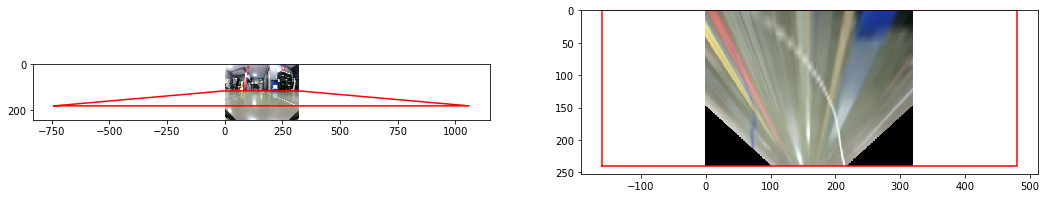

In [20]:
fig = plt.figure(figsize=(18, 6))

img = cv2.imread('test_images/blue1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


img_size = (img.shape[1], img.shape[0])

top_width = 320
left_top = (img_size[0] - top_width) / 2
right_top = left_top + top_width
bottom_width = 1800
left_bottom = (img_size[0] - bottom_width) / 2
right_bottom = left_bottom + bottom_width
top = 115
bottom = 180

src = np.float32([[left_bottom,bottom],
                 [left_top,top],
                 [right_top,top],
                 [right_bottom,bottom]])

width = 640
left = (img_size[0] - width) / 2
right = left + width
top = 0
bottom = 240
dst = np.float32([[left,bottom],
                 [left,top],
                 [right,top],
                 [right,bottom]])

a = fig.add_subplot(1, 2, 1)
plt.imshow(img)
a.plot(np.append(src[:,0],src[0,0]), np.append(src[:,1],src[0,1]), '-r')

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(img, M, img_size)

a = fig.add_subplot(1, 2, 2)
plt.imshow(warped)
_ = a.plot(np.append(dst[:,0],dst[0,0]), np.append(dst[:,1],dst[0,1]), '-r')

# Reflections removal

See "Reflection Removal" notebook document.

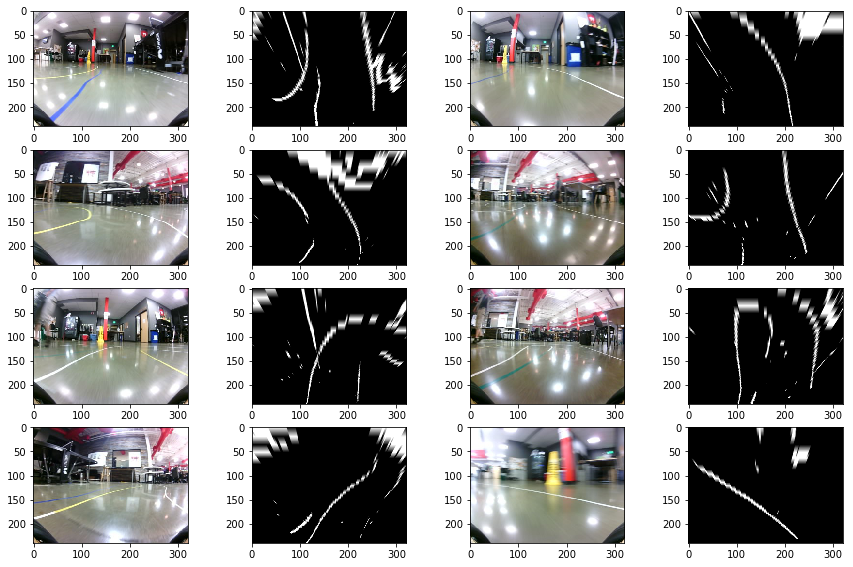

In [21]:
img_paths = glob.glob('test_images/*.jpg')
fig = plt.figure(figsize=(15, 20))
cols = 4
rows = len(img_paths)
i = 1

def preprocess_line_finding(img_raw, M, inrange=((38, 61, 112), (139, 255, 255))):
    """ Preprocess before line finding.
    """
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2HSV)[:, :, 1]
    img = cv2.Sobel(img, -1, 1, 0, ksize=3)
    img = img > 127
    
    img1 = cv2.cvtColor(img_raw, cv2.COLOR_BGR2HSV)[:, :, 2]
    img1 = cv2.Sobel(img1, -1, 0, 1, ksize=3)
    img1 = img1 > 127
    
    img2 = cv2.cvtColor(img_raw, cv2.COLOR_BGR2HSV)
    img2 = cv2.inRange(img2, (38, 61, 112), (139, 255, 255))
    img2 = img2 > 25.5

    final_img = (img==1) | (img1==1) | (img2==1)
    
    f3 = np.stack((final_img, final_img, final_img), axis=2)
    f3 = (f3 * 255.0).astype(np.uint8)

    warped = cv2.warpPerspective(f3, M, (img_raw.shape[1], img_raw.shape[0]))
    return warped[:, :, 0]

for img_path in img_paths:
    ax = fig.add_subplot(rows, cols, i)
    img_raw = cv2.imread(img_path)
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    i += 1

    ax = fig.add_subplot(rows, cols, i)
    warped = preprocess_line_finding(img_raw, M)
    plt.imshow(warped, cmap='gray')
    i += 1

# Histogram

In [22]:
importance = 1
weights = np.array([range(5)])*importance
print(weights.T)
x = np.array([[0, 1, 1, 0, 1, 0],
              [0, 1, 1, 1, 0, 1],
              [0, 0, 1, 0, 1, 1],
              [0, 1, 1, 1, 0, 0],
              [1, 1, 0, 1, 1, 0]])
x = weights.T ** x
print(x)

# For center weights, convert as follows:
# 0 1 2 3 4 5 6 7 to 1 2 3 4 4 3 2 1
# (changes: 1, 1, 1, 1, 0, -2, -4. -6)
# In other words, points closer to the center have higher scores.

cweights = np.array([range(6)])
hlen = int(cweights.shape[1]/2) # half-length
adj = [1] * hlen # adjustments
for i in range(hlen):
    v = -i*6
    adj.append(v)
cweights += adj
print(cweights)
x += cweights
print(x)
histogram = np.sum(x[1:,:], axis=0)
histogram

[[0]
 [1]
 [2]
 [3]
 [4]]
[[1 0 0 1 0 1]
 [1 1 1 1 1 1]
 [1 1 2 1 2 2]
 [1 3 3 3 1 1]
 [4 4 1 4 4 1]]
[[ 1  2  3  3 -2 -7]]
[[ 2  2  3  4 -2 -6]
 [ 2  3  4  4 -1 -6]
 [ 2  3  5  4  0 -5]
 [ 2  5  6  6 -1 -6]
 [ 5  6  4  7  2 -6]]


array([ 11,  17,  19,  21,   0, -23])

test_images/blue2.jpg
(240, 320)
line 1 error: 2.003197222678263 (v)
line 1 coefs: [ -3.01109314e-04   2.15780900e-01   1.02809741e+02]
line 2 error: 2.0623786094199303 (v)
line 2 coefs: [ -1.65290304e-03   5.19322071e-01   2.19258422e+02]


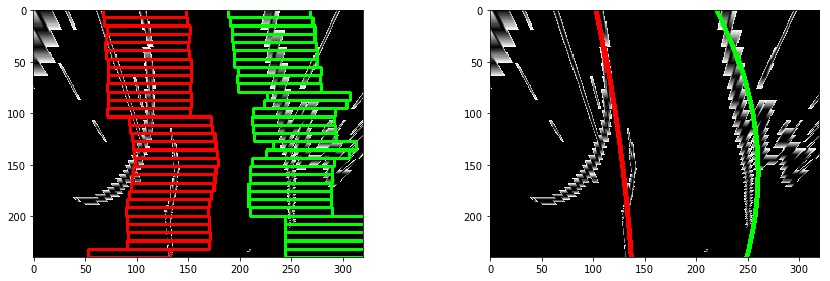

In [32]:
fig = plt.figure(figsize=(15, 10))
local_paths = img_paths[0:1]

i = 1
total = len(local_paths) * 2
cols = 2
for img_path in local_paths:
    print(img_path)
    a = fig.add_subplot((total/cols)+1, cols, i)
    img_raw = cv2.imread(img_path)
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

    warped = preprocess_line_finding(img_raw, M)
    print(warped.shape)
    finder = FindLinesSlidingWindows(nwindows=30, window_minpix=10, left_search_margin=40, right_search_margin=40,
                                     error_threshold=36, window_patience=15, window_empty_px=5,
                                     lr_start_slack=0.1, error_top_percentile=85, center_importance=4,
                                     debug=True, debug_dir='v', debug_show_lines=False, debug_error_detail=False)

    fits = finder.process(warped)

    final_img = annotate_with_lines(warped, fits)
    
    i += 1
    a = fig.add_subplot((total/cols)+1, cols, i)
    plt.imshow(final_img, cmap='gray')
    i += 1

test_images/blue2.jpg
line 1 error: 8.360940818238808 (v)
line 1 coefs: [ -4.83616310e-04   1.02150306e-01   1.32237578e+02]
line 2 error: 0.2518622458682909 (v)
line 2 coefs: [ -4.34698287e-04   2.13088936e-01   2.27061009e+02]
test_images/blue1.jpg
line 1 error: 23.139488240731605 (v)
line 1 coefs: [ -3.70616977e-04   2.60687372e-02   8.10911300e+01]
line 2 error: 0.2298479992460551 (v)
line 2 coefs: [ -1.67372089e-03   8.30107232e-01   1.10810606e+02]
test_images/yellow2.jpg
line 1 error: 9.770860146050339 (h)
line 1 coefs: [ -1.76113816e-03   4.95505656e-01   6.57845911e+01]
line 2 error: 0.5606001866842376 (v)
line 2 coefs: [  7.42821207e-04   2.68951711e-01   1.45053844e+02]
Remove overlapping right line.
test_images/green1.jpg
line 1 error: 26.403833304610075 (h)
line 1 coefs: [  1.12206609e-04  -5.61971704e-02   1.42034319e+02]
line 2 error: 0.25279943552276873 (v)
line 2 coefs: [  1.09430102e-03  -5.37662915e-03   1.99269533e+02]
Remove overlapping right line.
test_images/midd

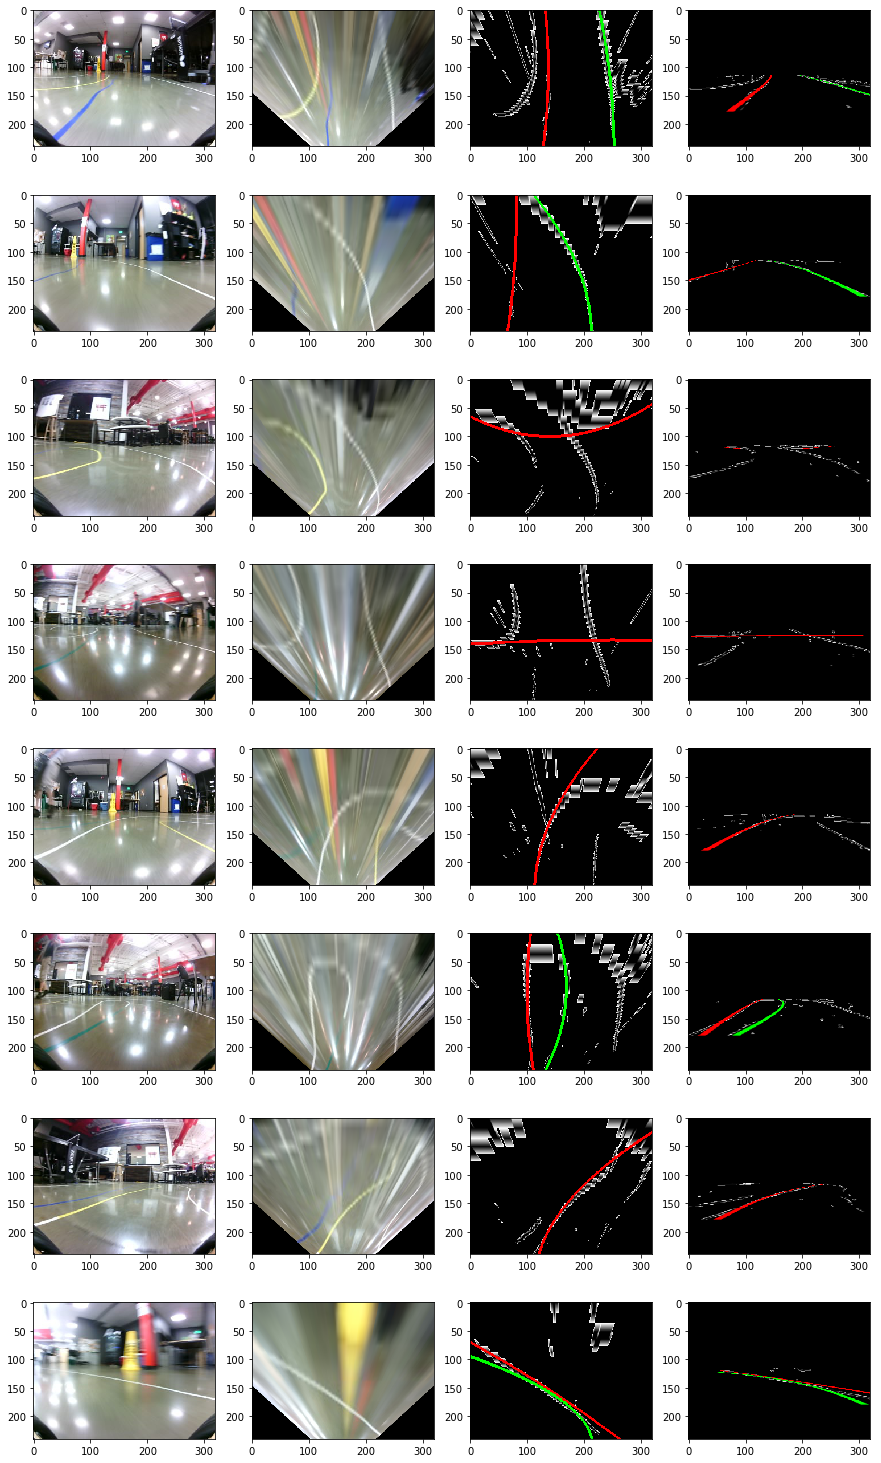

In [29]:
fig = plt.figure(figsize=(15, 30))
local_paths = img_paths

i = 1
total = len(local_paths)*4
cols = 4
for img_path in local_paths:
    print(img_path)
    img_raw = cv2.imread(img_path)
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    warped = cv2.warpPerspective(img, M, img_size)

    # Display the original, undistorted, and warped image
    a = fig.add_subplot((total/cols)+1, cols, i)
    plt.imshow(img)
    i+=1
    a = fig.add_subplot((total/cols)+1, cols, i)
    plt.imshow(warped)
    i+=1
    
    # Find lines
    a = fig.add_subplot((total/cols)+1, cols, i)
    finder = FindLinesSlidingWindows(nwindows=30, window_minpix=10, left_search_margin=10, right_search_margin=10,
                                     error_threshold=36, window_patience=15, window_empty_px=5,
                                     lr_start_slack=0.1, error_top_percentile=85, center_importance=4,
                                     debug=True)
    preprocessed = preprocess_line_finding(img_raw, M)
    fits = finder.process(preprocessed)
    final_img = annotate_with_lines(preprocessed, fits, keep_background=True)
    plt.imshow(final_img)
    i += 1
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    a = fig.add_subplot((total/cols)+1, cols, i)
    final_img = cv2.warpPerspective(final_img, Minv, (final_img.shape[1], final_img.shape[0]))
    plt.imshow(final_img)
    i += 1

## Use blob to find lines

It does not work better than sliding windows, apparently.

test_images/yellow2.jpg
7
(240, 320)
shape 1
(1995, 2)
shape 2
(10018, 2)
shape 3
(151, 2)
shape 4
(560, 2)
shape 5
(15, 2)
shape 6
(11, 2)
total items: 10195
[[    0     0   320   240 64050]
 [   24     0    92   128  1995]
 [  114     0   163   182 10018]
 [  277   118    27    23   151]
 [   82   158    47    46   560]
 [  192   180     5     7    15]
 [  210   207     5     4    11]]
[[ 156.33851678  131.83812646]
 [  71.16641604   50.29373434]
 [ 198.06598123   50.4332202 ]
 [ 290.31125828  128.27152318]
 [ 108.62678571  184.60714286]
 [ 194.2         183.2       ]
 [ 212.27272727  208.63636364]]
[-96, -95, -94, -93, -92, -91, -90, -89, -88, -87, -86, -85, -84, -83, -82, -81, -80, -79, -78, -77, -76, -75, -74, -73, -72, -71, -70, -69, -68, -67, -66, -65, -64, -63, -62, -61, -60, -59, -59, -58, -57, -56, -55, -54, -53, -52, -51, -50, -49, -48, -47, -47, -46, -45, -44, -43, -42, -41, -40, -39, -39, -38, -37, -36, -35, -34, -33, -33, -32, -31, -30, -29, -28, -28, -27, -26, -25, -24, 

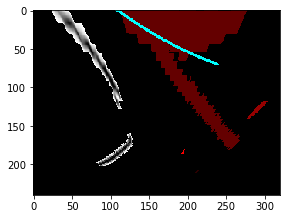

In [13]:
fig = plt.figure(figsize=(15, 10))
local_paths = img_paths[2:3]

i = 1
total = len(local_paths)
cols = 3
for img_path in local_paths:
    print(img_path)
    a = fig.add_subplot((total/cols)+1, cols, i)
    img_raw = cv2.imread(img_path)
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

    warped = preprocess_line_finding(img_raw, mtx, dist, M)
    finder = FindLinesSlidingWindows(window_minpix=50, subsequent_search_margin=20,
                                     always_recalculate=True, debug=True)
    # You need to choose 4 or 8 for connectivity type
    connectivity = 4  
    # Perform the operation
    output = cv2.connectedComponentsWithStats(warped, connectivity)
    centroids = output[3]
    # Get the results
    # The first cell is the number of labels
    num_labels = output[0]
    print(num_labels)
    # The second cell is the label matrix
    labels = output[1]
    print(labels.shape)
    
    ylist = []
    xlist = []
    f3 = np.stack((warped, warped, warped), axis=2)
    f3 = (f3 * 255.0).astype(np.uint8)
    for label in range(1, num_labels):
        pos = np.argwhere(labels==label)
        print("shape", label)
        print(pos.shape)
        posx = pos[:, 0]
        posy = pos[:, 1]
        if centroids[label][0] > warped.shape[1]/2:
            f3[posx, posy] = ((label * 50), 0, 0)
            xlist += list(pos[:, 0])
            ylist += list(pos[:, 1])
            
    print("total items:", len(ylist))
    fit = np.polyfit(ylist, xlist, 2)
    fitx = []
    for y in range(warped.shape[0]):
        x = int(fit[0]*y**2 + fit[1]*y + fit[2])
        fitx.append(x)
    
    pts = np.array([np.transpose(np.vstack([[range(warped.shape[0])], fitx]))], np.int32)
    cv2.polylines(f3, np.int_([pts]), False, (0, 255, 255), thickness=2)
        
    # The third cell is the stat matrix
    stats = output[2]
    print(stats)
    # The fourth cell is the centroid matrix
    print(centroids)
    plt.imshow(f3)

    print(fitx)
#     lines = finder.process(warped)
#     final_img = annotate_with_lines(warped, lines)
#     plt.imshow(final_img, cmap='gray')

    i += 1

In [18]:
def labels_generator():
    for i in range(10):
        yield i
            
labels = labels_generator()

for label in labels:
    print(label)

0
1
2
3
4
5
6
7
8
9
